In [1]:
import gc
import time
import numpy as np
import pandas as pd
from sklearn.cross_validation import train_test_split
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['OMP_NUM_THREADS'] = '4'

path = ''
dtypes = {
        'ip'            : 'uint32',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        'click_id'      : 'uint32'
        }

print('loading')

train_columns = ['ip', 'app', 'device', 'os', 'channel', 'click_time', 'is_attributed']
test_columns = ['click_id', 'ip', 'app', 'device', 'os', 'channel', 'click_time']
train_df = pd.read_csv(path+"train.csv", dtype=dtypes, skiprows = range(1, 131886954), usecols=train_columns)
test_df = pd.read_csv(path+"test.csv", dtype=dtypes, usecols=test_columns)

print('finished loading')

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


loading
finished loading


In [2]:
def prep_data(d):
    print('hour, day, wday....')
    d['hour'] = pd.to_datetime(d.click_time).dt.hour.astype('uint8')
    d['day'] = pd.to_datetime(d.click_time).dt.day.astype('uint8')
    d['wday']  = pd.to_datetime(d.click_time).dt.dayofweek.astype('uint8')
    print('grouping by ip-day-hour combination....')
    gp = d[['ip', 'day', 'hour', 'channel']].groupby(by=['ip', 'day', 'hour'])[['channel']].count().reset_index().rename(index=str, columns={'channel': 'qty'})
    d = d.merge(gp, on=['ip', 'day', 'hour'], how='left')
    del gp; gc.collect()
    print('group by ip-app combination....')
    gp = d[['ip', 'app', 'channel']].groupby(by=['ip', 'app'])[['channel']].count().reset_index().rename(index=str, columns={'channel': 'ip_app_count'})
    d = d.merge(gp, on=['ip', 'app'], how='left')
    del gp; gc.collect()
    print('group by ip-app-os combination....')
    gp = d[['ip', 'app', 'os', 'channel']].groupby(by=['ip', 'app', 'os'])[['channel']].count().reset_index().rename(index=str, columns={'channel': 'ip_app_os_count'})
    d = d.merge(gp, on=['ip', 'app', 'os'], how='left')
    del gp; gc.collect()
    print("vars and d type....")
    d['qty'] = d['qty'].astype('uint16')
    d['ip_app_count'] = d['ip_app_count'].astype('uint16')
    d['ip_app_os_count'] = d['ip_app_os_count'].astype('uint16')
    print("label encoding....")
    from sklearn.preprocessing import LabelEncoder
    d[['app', 'device', 'os', 'channel', 'hour', 'day', 'wday']].apply(LabelEncoder().fit_transform)
    print('dropping')
    d.drop(['click_time', 'ip'], 1, inplace=True)
    
    return d

In [3]:
train_df = prep_data(train_df)
test_df = prep_data(test_df)
print("finished")

hour, day, wday....
grouping by ip-day-hour combination....
group by ip-app combination....
group by ip-app-os combination....
vars and d type....
label encoding....
dropping
hour, day, wday....
grouping by ip-day-hour combination....
group by ip-app combination....
group by ip-app-os combination....
vars and d type....
label encoding....
dropping
finished


In [4]:
RANDOM_SEED = 1
import random
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

X_train, X_test = train_test_split(train_df, test_size=0.1, random_state=RANDOM_SEED)

y_train = X_train['is_attributed']
X_train = X_train.drop(['is_attributed'], axis=1)
y_test = X_test['is_attributed']
X_test = X_test.drop(['is_attributed'], axis=1)

In [5]:
from keras.layers import Input, Embedding, Dense, Flatten, Dropout, concatenate
from keras.layers import BatchNormalization, SpatialDropout1D, Conv1D
from keras.callbacks import Callback
from keras.models import Model
from keras.optimizers import Adam

Using TensorFlow backend.


In [6]:
X_train.head()

,app,device,os,channel,hour,day,wday,qty,ip_app_count,ip_app_os_count
31313339,14,1,19,489,9,9,3,44,36,10
30619767,20,1,23,259,9,9,3,47,45,3
2638855,1,1,19,349,0,9,3,45,38,16
19147114,9,1,26,215,5,9,3,331,472,4
36803705,9,1,37,466,11,9,3,44,185,7


In [7]:
def get_keras_data(dataset):
    X = {
        'app': np.array(dataset.app),
        'ch': np.array(dataset.channel),
        'dev': np.array(dataset.device),
        'os': np.array(dataset.os),
        'h': np.array(dataset.hour),
        'd': np.array(dataset.day),
        'wd': np.array(dataset.wday),
        'qty': np.array(dataset.qty),
        'c1': np.array(dataset.ip_app_count),
        'c2': np.array(dataset.ip_app_os_count)
    }
    return X

train = get_keras_data(X_train)
test = get_keras_data(X_test)

In [8]:
max_app = np.max([train_df['app'].max(), test_df['app'].max()])+1
max_ch = np.max([train_df['channel'].max(), test_df['channel'].max()])+1
max_dev = np.max([train_df['device'].max(), test_df['device'].max()])+1
max_os = np.max([train_df['os'].max(), test_df['os'].max()])+1
max_h = np.max([train_df['hour'].max(), test_df['hour'].max()])+1
max_d = np.max([train_df['day'].max(), test_df['day'].max()])+1
max_wd = np.max([train_df['wday'].max(), test_df['wday'].max()])+1
max_qty = np.max([train_df['qty'].max(), test_df['qty'].max()])+1
max_c1 = np.max([train_df['ip_app_count'].max(), test_df['ip_app_count'].max()])+1
max_c2 = np.max([train_df['ip_app_os_count'].max(), test_df['ip_app_os_count'].max()])+1

In [9]:
emb_n = 50

in_app = Input(shape=[1], name = 'app')
emb_app = Embedding(max_app, emb_n)(in_app)
in_ch = Input(shape=[1], name = 'ch')
emb_ch = Embedding(max_ch, emb_n)(in_ch)
in_dev = Input(shape=[1], name = 'dev')
emb_dev = Embedding(max_dev, emb_n)(in_dev)
in_os = Input(shape=[1], name = 'os')
emb_os = Embedding(max_os, emb_n)(in_os)
in_h = Input(shape=[1], name = 'h')
emb_h = Embedding(max_h, emb_n)(in_h) 
in_d = Input(shape=[1], name = 'd')
emb_d = Embedding(max_d, emb_n)(in_d) 
in_wd = Input(shape=[1], name = 'wd')
emb_wd = Embedding(max_wd, emb_n)(in_wd) 
in_qty = Input(shape=[1], name = 'qty')
emb_qty = Embedding(max_qty, emb_n)(in_qty) 
in_c1 = Input(shape=[1], name = 'c1')
emb_c1 = Embedding(max_c1, emb_n)(in_c1) 
in_c2 = Input(shape=[1], name = 'c2')
emb_c2 = Embedding(max_c2, emb_n)(in_c2) 
fe = concatenate([(emb_app), (emb_ch), (emb_dev), (emb_os), (emb_h), 
                 (emb_d), (emb_wd), (emb_qty), (emb_c1), (emb_c2)])

In [10]:
s_dout = SpatialDropout1D(0.25)(fe)

fl1 = Flatten()(s_dout)
conv1 = Conv1D(70, kernel_size=2, strides=1, padding='same')(s_dout)
fl2 = Flatten()(conv1)
conv2 = Conv1D(70, kernel_size=4, strides=1, padding='same')(s_dout)
fl3 = Flatten()(conv2)

concat = concatenate([(fl1), (fl2), (fl3)])

x = Dropout(0.25)(Dense(500, activation='relu')(concat))
x = Dropout(0.35)(Dense(750, activation='relu')(x))
x = Dropout(0.45)(Dense(1000, activation='relu')(x))
outp = Dense(1, activation='sigmoid')(x)

model = Model(inputs=[in_app,in_ch,in_dev,in_os,in_h,in_d,in_wd,in_qty,in_c1,in_c2], outputs=outp)

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


In [11]:
batch_size = 50000
epochs = 1
exp_decay = lambda init, fin, steps: (init/fin)**(1/(steps-1)) - 1
steps = int(len(train_df) / batch_size) * epochs
lr_init, lr_fin = 0.0025, 0.0001
lr_decay = exp_decay(lr_init, lr_fin, steps)
optimizer_adam = Adam(lr=0.0025, decay=lr_decay)
model.compile(loss='binary_crossentropy', optimizer=optimizer_adam, metrics=['accuracy'])

In [12]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
app (InputLayer)                (None, 1)            0                                            
__________________________________________________________________________________________________
ch (InputLayer)                 (None, 1)            0                                            
__________________________________________________________________________________________________
dev (InputLayer)                (None, 1)            0                                            
__________________________________________________________________________________________________
os (InputLayer)                 (None, 1)            0                                            
__________________________________________________________________________________________________
h (InputLa

In [13]:
class_weight = {0:.01,1:.99} # magic
model.fit(train, y_train, batch_size=batch_size, epochs=1, class_weight=class_weight, shuffle=True, validation_data=(test, y_test), verbose=1)

Train on 47715243 samples, validate on 5301694 samples
Epoch 1/1
47715243/47715243 [==============================] - 678s 14us/step - loss: 0.0019 - acc: 0.9850 - val_loss: 0.0612 - val_acc: 0.9855


In [14]:
predictions = model.predict(test, batch_size=batch_size, verbose=1)

5301694/5301694 [==============================] - 21s 4us/step


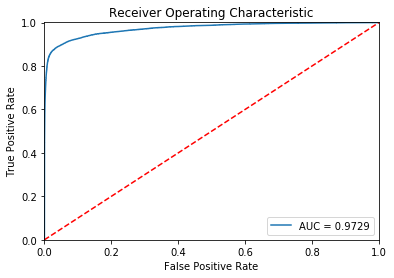

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

fpr, tpr, thresholds = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

In [16]:
ids = test_df['click_id']
test_df.drop('click_id', axis=1, inplace=True)
t = get_keras_data(test_df)
sub_preds = model.predict(t, batch_size=batch_size, verbose=1)
sub = pd.DataFrame()
sub['click_id'] = ids
sub['is_attributed'] = sub_preds
sub.to_csv('dl_sub_epoch_total.csv', index=False)

18790469/18790469 [==============================] - 67s 4us/step
